# DSCI 100 Project Proposal - Group 8, Section 006

## **I. Title**

#### Classification of Wines Into 3 Cultivars on the Basis of Various Parameters

## **II. Introduction**

Winemaking is a complex process involving and affected by various factors that countless winemakers and connoisseurs have sought to understand in their quest towards high quality wine. Since wine is created from the fermentation of grapes, there is an inherent relationship between the cultivar, the specific variety of grape that is bred & cultivated for winemaking, and the wine itself. Each cultivar is known for distinct characteristics, taste, and style (Marzano et al., 2016). Various studies over the years have been conducted on how specific cultivars are related to different physical and chemical profiles (Restuccia et al., 2017).

Based on this connection, the group will be answering the following question: can a wine’s chemical composition be used to predict the grape cultivar that it was made from? The data set that will be used is named Wine, taken from the UC Irvine Machine Repository (Aeberhard & Forina, 1991). It is derived from a chemical analysis conducted on wines produced from grapes of 3 different cultivars, but within the same area in Italy. 13 different characteristics were measured and quantified from the 3 wines. The amount of certain chemical compounds comprise most of the data, such as alcohol content. 178 observations are present in the data set, each classified as either 1, 2, or 3 to indicate its cultivar. 

## **III. Reading and Wrangling the Data**

In [1]:
# loading all the packages we need for our proposal
library(tidyverse)
library(utils)
library(tidymodels)
library(rvest)
library(GGally)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# Source: https://archive.ics.uci.edu/dataset/109/wine

# This cell proceeds to connect to the URL and download the data as tempfile to avoid
# having to download it locally.
temp <- tempfile()
url_ <- "https://archive.ics.uci.edu/static/public/109/wine.zip"
download.file(url_,temp)

In [3]:
# Converting our response variable into factor!
# wine_data <- read_delim("wine.data", delim = ",", col_name = FALSE)|>
#              mutate(X1 = as_factor(X1)) 

# Using this method, we successfully read the zipped data directly from source website 
# without downloading it!
wine_data <- read_delim(unz(temp,"wine.data"), delim = ",", col_name = FALSE)|>
             mutate(X1 = as_factor(X1))
unlink(temp)

# We tried to scrap column names directly from the webpage, but it just missed some column names due to 
# unknown reasons, and even TAs could not explain why and help us fix this issue. Here are the codes that 
# worked partly, which followed the textbook and ran with no errors. 
# (If possible, could you provide us with some feedback regarding the method of scraping web data?)

# webpage <- read_html("https://archive.ics.uci.edu/dataset/109/wine")
# col_data <- html_nodes(webpage, "td:nth-child(1)")
# col_text <- html_text(cell_data)

# colnames(wine_data) <- col_text

# To proceed, we decided to copy the column names directly from the source page (given above)
colnames(wine_data) <- c('class', 'Alcohol', 'Malicacid', 'Ash', 'Alcalinity_of_ash', 'Magnesium', 'Total_phenols', 'Flavanoids', 
                         'Nonflavanoid_phenols','Proanthocyanins','Color_intensity', 'Hue','OD280_OD315_of_diluted_wines',
                         'Proline')

wine_data 
# We can see that after adding column names, the data is already in a tidy format.
# Each observation has its own row, with each column referencing a single variable, and each cell
# containing one value. 

Rows: 178 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


class,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280_OD315_of_diluted_wines,Proline
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.2,0.59,1.56,835
3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.3,0.60,1.62,840
3,14.13,4.10,2.74,24.5,96,2.05,0.76,0.56,1.35,9.2,0.61,1.60,560


## **IV. Preliminary Analysis with Visualization**

In [4]:
# Now, we will explore the data and see the distribution of the 3 classes
num_obs <- nrow(wine_data)
num_obs
wine_data|>
    group_by(class)|>
     summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )
# The result shows that the data set has a relatively balanced distribution of the 3 classes

[1] 178

class,count,percentage
<fct>,<int>,<dbl>
1,59,33.14607
2,71,39.88764
3,48,26.96629


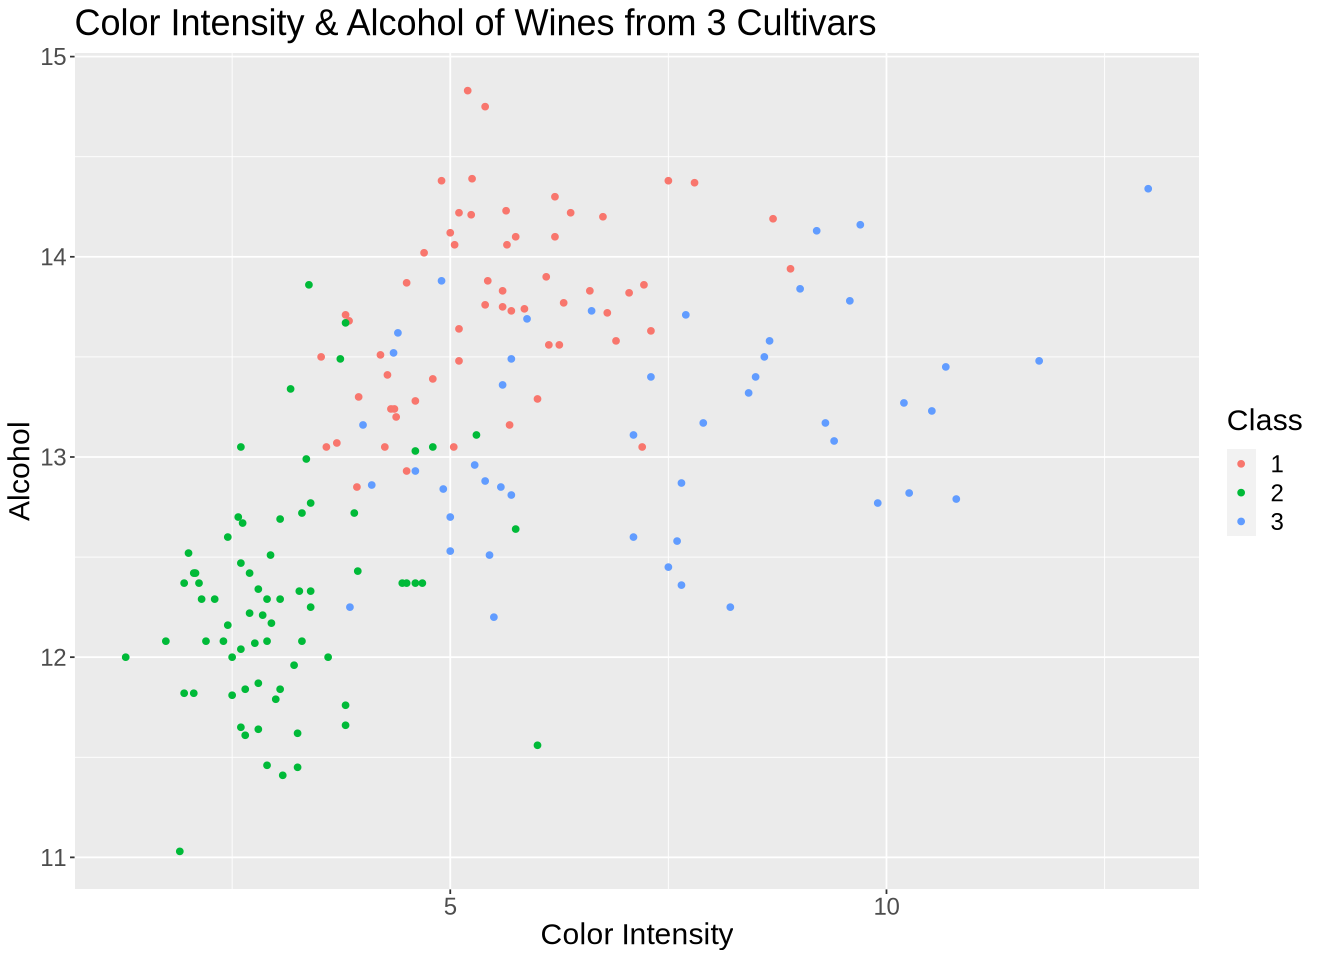

In [5]:
# We plot the color intensity and alcohol to see how the classes are distributed 
# with regards to the two variables.
# Note: No units were provided in the source of the data set so none are included in axes labels.
options(repr.plot.width =11 , repr.plot.height = 8)
Color_intensity_Alcohol <- ggplot(wine_data, aes(x = Color_intensity, y = Alcohol, color = class)) +
                           geom_point() +
                           labs(x = "Color Intensity", y = "Alcohol", color = "Class") + 
                           ggtitle("Color Intensity & Alcohol of Wines from 3 Cultivars") +
                           theme(text = element_text(size = 18))
                           
Color_intensity_Alcohol

In [6]:
# We set the seed to make sure our outcome is repeatable
set.seed(333)

wine_split <- initial_split(wine_data, prop = 0.75, strata = class)
wine_training <- training(wine_split)
wine_testing <- testing(wine_split)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin




[1] "Proline"                      "Flavanoids"                  
[3] "Alcohol"                      "Color_intensity"             
[5] "OD280_OD315_of_diluted_wines"

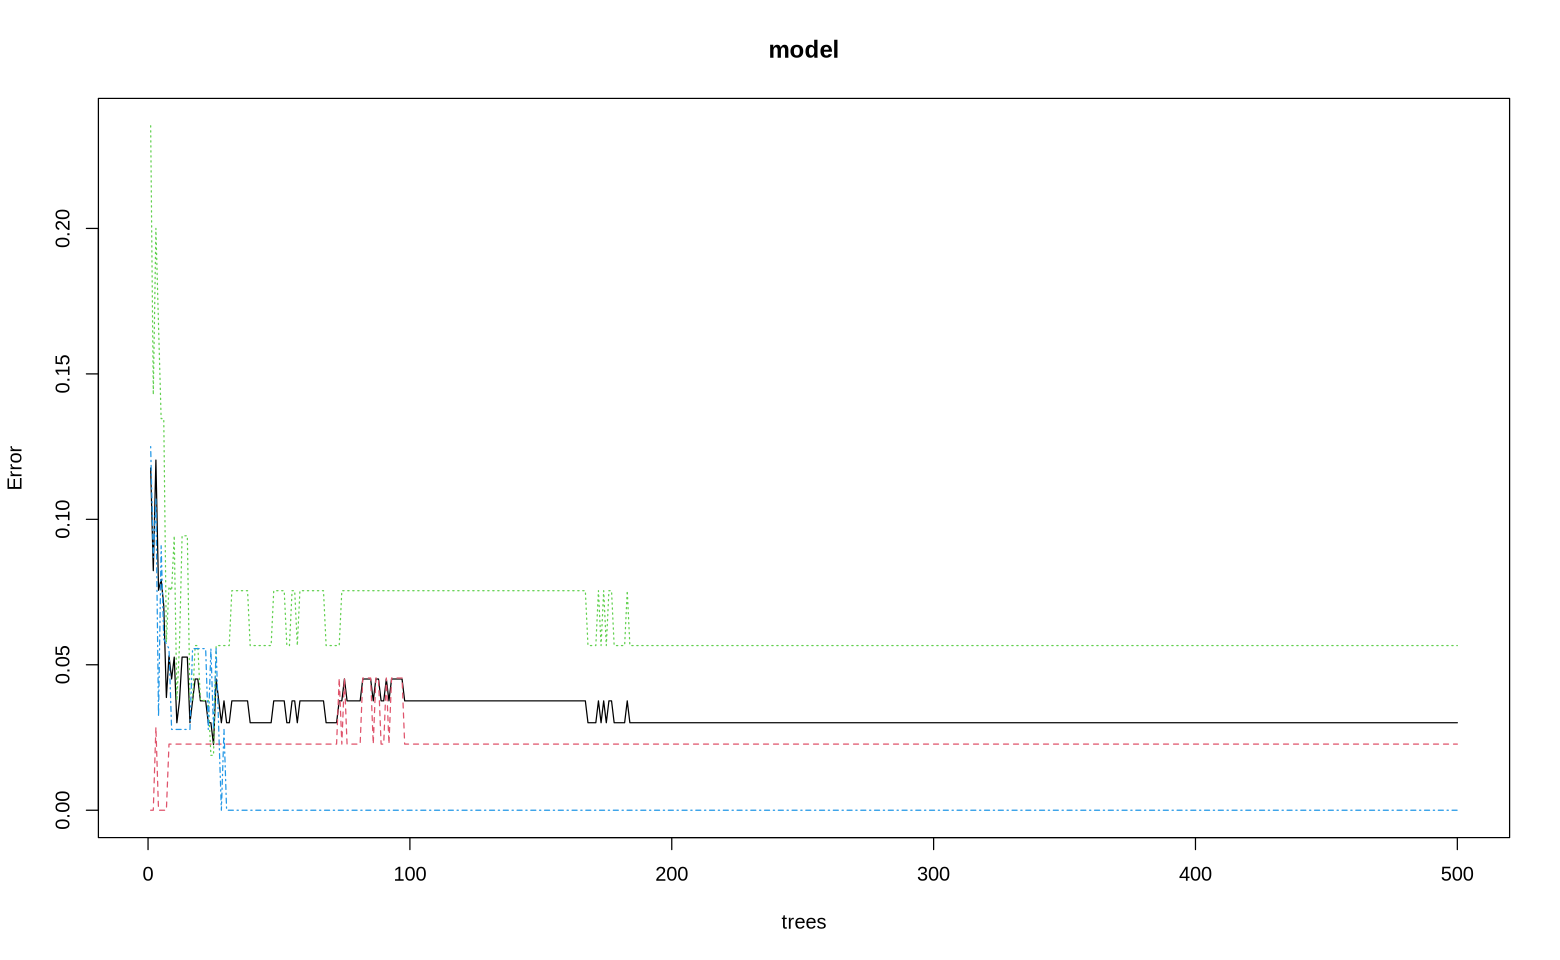

In [7]:
# We set the seed to make sure our outcome to be repeatable
set.seed(333)

# Using the random forest method to find out the 5 variables that have the strongest correlation with the 
# class variable (Breiman et al., 2022; R-Bloggers, 2021)
library(randomForest)
model <- randomForest(class ~ ., data = wine_training)
importance <- importance(model)
important_variables <- data.frame(Variable = row.names(importance), 
                            Importance = importance[, "MeanDecreaseGini"], 
                            row.names = NULL)|>
                 slice_max(importance, n = 5)|>
                 pull(Variable)
important_variables 
# Now, we know the top 5 most important variables. Even if we changed the seed to conduct different tests, 
# the results are very stable and convincing.
# The results for the five variables with the strongest correlations are consistent, although there may 
# be differences in order.

options(repr.plot.width =13 , repr.plot.height = 8)
plot(model) 
# The plot shows that our random forest model has a very high accuracy in the end, 
# with the errors for all variables below 0.1.

In [8]:
wine_training_select <- select(wine_training,class, all_of(important_variables))|>
                 glimpse()

# Using group_by + summarize to see the sample number and percentage of each class and the mean value 
# of each variable for the three classes
num_obs_training <- nrow(wine_training_select)
group_by(wine_training_select, class)|>
summarize(count = n(),
          percentage = n() / num_obs_training * 100,
          across(all_of(important_variables), mean))
# The results show that there is a significant difference in the mean values of the different variables 
# depending on the factor (class). Therefore, this data is suitable for classification purposes.

Rows: 133
Columns: 6
$ class                        <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ Proline                      <dbl> 1050, 1185, 1480, 1450, 1045, 1045, 1510,…
$ Flavanoids                   <dbl> 2.76, 3.24, 3.49, 3.39, 2.98, 3.15, 3.32,…
$ Alcohol                      <dbl> 13.20, 13.16, 14.37, 14.20, 14.83, 13.86,…
$ Color_intensity              <dbl> 4.38, 5.68, 7.80, 6.75, 5.20, 7.22, 5.75,…
$ OD280_OD315_of_diluted_wines <dbl> 3.40, 3.17, 3.45, 2.85, 2.85, 3.55, 3.17,…


class,count,percentage,Proline,Flavanoids,Alcohol,Color_intensity,OD280_OD315_of_diluted_wines
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,44,33.08271,1115.4545,3.0172727,13.70568,5.611818,3.110227
2,53,39.84962,510.4906,2.1288679,12.16642,3.132642,2.784906
3,36,27.06767,629.4444,0.7563889,13.07722,7.530833,1.643611


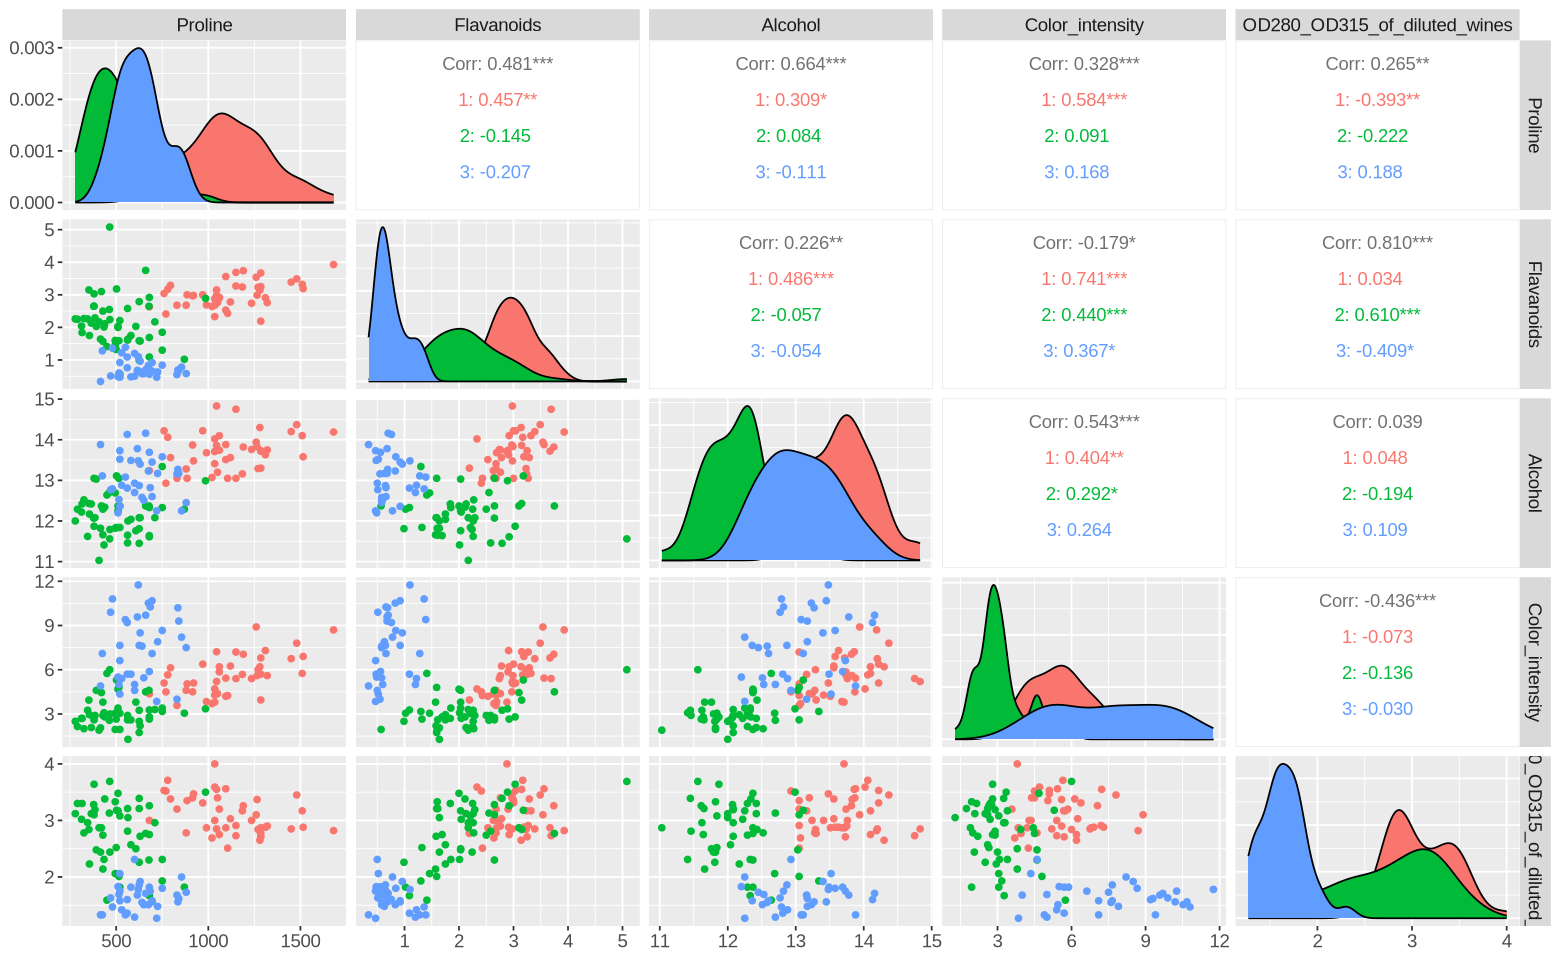

In [9]:
options(repr.plot.width =13 , repr.plot.height = 8) 

# We use the scatter matrix to show the distribution of classes and the correlation among our 
# selected variables.
ggpairs(wine_training_select, columns = important_variables, ggplot2::aes(colour=class)) + theme(text = element_text(size = 14))
# The outcome reveals that the 5 variables we selected as predictors have clear correlations with the 
# class variables in their distributions.
# They also have some degree of mutual correlations, but this wouldn't affect the effectiveness of the 
# K-nearest neighbor method too much, since we can see clear boundaries for the class distribution.

## **V. Methodology**

To reiterate, this project aims to predict differing origins of the grapes used in 3 different wines based on the following parameters: **proline concentration, flavinoids present, alcohol concentration, color intensity, and the amount of OD280/OD315**, which is an indicator of protein content (Jana et al., 2023). These variables were determined via the random forest method, which isolated these 5 out of the 13 variables in the data set to have the strongest correlation with the class of wine. The proposed overall flow of the method is as follows - 

1. We will **split the data** into a reasonable separation of test data and training data.

2. **The classifier (K-nearest neighbors) will be built**. To do this, we will process the data by standardizing it (scaling and centering) then create the classifier using only the training data.
 
3. The test data will be used to **gauge the accuracy** of the method. This will be done by predicting the classes of wine in our test data set. The performance of the classifier will be evaluated using metrics and a confusion matrix and tuned to determine the best K for the model. 

**Visualisations** 

a. Estimated accuracy against the number of neighbors: to determine the best K for the model

b. Estimated accuracy against the number of predictors: to determine how many of the variables should be used as predictors in the classifier

c. Stacked bar plot: to visualize the proportion of accurate versus inaccurate predictions in the test data for each class of wine across different neighbors and numbers of predictors


## **VI. Expected outcomes and Significance**

In this project, our group expects to be able to predict the grape cultivar of a wine based on its chemical composition with high accuracy. The levels of chemical compounds in the wine should be able to rigorously determine which of the cultivars it originated from. 

The findings of this project could be impactful for winemakers and wine connoisseurs because being able to accurately predict the origin of the grapes from a wine can provide valuable information on the distinct characteristics of cultivars. This can be a tool in wine quality assurance and authentication. Additionally, it can facilitate research into the relationships between grape cultivars and the sensory attributes of wine. 

Future projects can delve into the prediction of specific vineyards or even the individual winemaker simply from the chemical composition of a wine. 

##### References

1. Aeberhard, S. & Forina ,M. (1991). Wine. UCI Machine Learning Repository. https://doi.org/10.24432/C5PC7J. 

2. Breiman, L., Cutler, D. R., Liaw, A., & Wiener, M. (2022). randomForest: Breiman and Cutler's Random Forests for Classification and Regression. Retrieved from https://cran.r-project.org/web/packages/randomForest/randomForest.pdf 

3. Jana, D. K., Bhunia, P., Adhikary, S. D., & Mishra, A. (2023). Analyzing of salient features and classification of wine type based on quality through various neural network and support vector machine classifiers. Results in Control and Optimization, 11, 100219. https://doi.org/10.1016/j.rico.2023.100219. 

4. Marzano, M., Fosso, B., Manzari, C., Grieco, F., Intranuovo, M., Cozzi, G., Mulè, G., Scioscia, G., Valiente, G., Tullo, A., Sbisà, E., Pesole, G., & Santamaria, M. (2016). Complexity and Dynamics of the Winemaking Bacterial Communities in Berries, Musts, and Wines from Apulian Grape Cultivars through Time and Space. PLOS ONE, 11(6), e0157383. https://doi.org/10.1371/journal.pone.0157383. 

5. R-Bloggers. (2021, April 13). Random Forest in R. Retrieved from https://www.r-bloggers.com/2021/04/random-forest-in-r/ 

6. Restuccia, D., Sicari, V., Pellicanò, T. M., Spizzirri, U. G., & Loizzo, M. R. (2017). The impact of cultivar on polyphenol and biogenic amine profiles in Calabrian red grapes during winemaking. Food Research International, 102, 303-312. https://doi.org/10.1016/j.foodres.2017.10.012. 